In [1]:
from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import preprocessing as prep
import extraction as ext
import yaml
import importlib
from pyspark.ml.feature import Normalizer 
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pyspark.sql.functions as func
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
importlib.reload(prep)
# Get all the datasets and apply preprocessing 

with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)

spark = SparkSession.builder.appName("NYC_Taxi")\
    .config('spark.executor.memory', "4g")\
    .getOrCreate()

spark.conf.set("spark.sql.execution.arrow.enabled","true")        

print(f"Get Taxi Data")
psdf_taxi = ext.get_taxi_data(spark, cfg)

print(f"Get zones")
df_zones = ext.get_zones(cfg)
print(f"Clean zones")
df_zones = prep.clean_zone_data(df_zones)
psdf_zones=spark.createDataFrame(df_zones)

gdf_zones_shp = ext.get_zones_shapefile(cfg)
gdf_zones_shp = prep.clean_zone_shp_data(gdf_zones_shp)
gdf_zones_shp = prep.add_features_shp_data(gdf_zones_shp)
psdf_zones_shp = spark.createDataFrame(gdf_zones_shp[["OBJECTID", "lat", "lon"]])

print(f"Add features taxi")
psdf_taxi = prep.add_features_taxi_data(psdf_taxi, psdf_zones, psdf_zones_shp)

print(f"Clean Taxi Data")
psdf_taxi = prep.clean_taxi_data(psdf_taxi, cfg)

print(f"SPDF Taxi size: {psdf_taxi.count()}")



Get Taxi Data
Already downloaded file: yellow_tripdata_2017-01.parquet
Already downloaded file: yellow_tripdata_2017-03.parquet
Already downloaded file: yellow_tripdata_2017-06.parquet
Already downloaded file: yellow_tripdata_2017-11.parquet
Already downloaded file: yellow_tripdata_2017-12.parquet
Get zones
Already downloaded file: taxi+_zone_lookup.csv
Clean zones
Already downloaded file: taxi_zones.shp
Add features taxi
Clean Taxi Data
SPDF Taxi size: 3268189


In [3]:
psdf_taxi_sample = psdf_taxi.sample(1.0)
# psdf_taxi_sample = psdf_taxi_sample.na.fill(value=0)
# we had to remove Null values or Spark produced some errors
psdf_taxi_sample = psdf_taxi_sample.na.drop("any")
# psdf_taxi_sample.na.drop(subset=["tip_amount"])
psdf_taxi_sample.cache()

DataFrame[VendorID: bigint, tpep_pickup_datetime: timestamp, tpep_dropoff_datetime: timestamp, passenger_count: bigint, trip_distance: double, RateCodeID: bigint, store_and_fwd_flag: string, PULocationID: bigint, DOLocationID: bigint, payment_type: bigint, fare_amount: double, extra: double, mta_tax: double, tip_amount: double, tolls_amount: double, improvement_surcharge: double, total_amount: double, sum_amount: double, pu_month: int, pu_year: int, do_month: int, do_year: int, duration_in_min: double, tip_percentage: double, day_of_week: int, day_of_month: int, hour: int, PU_Borough: string, PU_Zone: string, PU_service_zone: string, DO_Borough: string, DO_Zone: string, DO_service_zone: string, PU_lat: double, PU_lon: double, DO_lat: double, DO_lon: double]

In [4]:
# include these category columns as one hot encoding
category_columns = ["VendorID", 
    "RateCodeID", 
    "store_and_fwd_flag", 
    "pu_month", 
    "day_of_week", 
    "hour", 
    "PU_Borough", 
    # "PU_Zone", 
    "PU_service_zone", 
    "DO_Borough", 
    # "DO_Zone", 
    "DO_service_zone"]  

indexer = StringIndexer(inputCols=category_columns, 
    outputCols=[column+"_index" for column in category_columns], handleInvalid='keep')    

psdf_taxi_vec = indexer.fit(psdf_taxi_sample).transform(psdf_taxi_sample)

ohe = OneHotEncoder(inputCols=[column+"_index" for column in category_columns], 
    outputCols=[column+"_OHEVector" for column in category_columns], handleInvalid='keep')

psdf_taxi_vec = ohe.fit(psdf_taxi_vec).transform(psdf_taxi_vec)

In [5]:
# nummeric columns 
numeric_columns = ['trip_distance', 
    'fare_amount', 'passenger_count',
    'extra', 'tolls_amount',     
    'day_of_month',    
    'PU_lat', 'PU_lon', 
    'DO_lat', 'DO_lon', 
    'duration_in_min'
    ]

target_column = "tip_percentage" #"tip_percentage" #"tip_amount"

category_columns_vec = [column+"_OHEVector" for column in category_columns]


mergeAssembler = VectorAssembler(
    inputCols = numeric_columns + category_columns_vec,
    outputCol = 'features',
    handleInvalid='keep')

v_df = mergeAssembler.transform(psdf_taxi_vec)
v_df.select(['features', target_column]).show(5)

+--------------------+------------------+
|            features|    tip_percentage|
+--------------------+------------------+
|(86,[0,1,2,5,6,7,...|              20.0|
|(86,[0,1,2,3,5,6,...|              20.0|
|(86,[0,1,2,5,6,7,...|0.5882352941176471|
|(86,[0,1,2,5,6,7,...|               0.0|
|(86,[0,1,2,5,6,7,...|               0.0|
+--------------------+------------------+
only showing top 5 rows



In [6]:
splits = v_df.randomSplit([0.7, 0.3], seed = 0)
train_df = splits[0]
test_df = splits[1]

In [7]:
# ideally we should optimize hyperparameters
# for timming restrictions we test only with these first parameters
gbt = GBTRegressor(featuresCol = 'features', labelCol = target_column, 
                   maxIter=10,
                   maxDepth=3)
gbt_model = gbt.fit(train_df)

gbt_predictions = gbt_model.transform(test_df)
gbt_predictions.select('prediction', target_column, 'features').show(5)

+------------------+------------------+--------------------+
|        prediction|    tip_percentage|            features|
+------------------+------------------+--------------------+
|17.924701096781373| 19.97245179063361|(86,[0,1,2,5,6,7,...|
| 17.74177454361299| 9.124087591240876|(86,[0,1,2,3,5,6,...|
|18.126690797492802|10.953825412874957|(86,[0,1,2,3,4,5,...|
| 18.08540423340303|               0.0|(86,[0,1,2,3,5,6,...|
|18.320362357142486|  19.9375866851595|(86,[0,1,2,3,4,5,...|
+------------------+------------------+--------------------+
only showing top 5 rows



In [8]:
gbt_evaluator = RegressionEvaluator(
    labelCol=gbt.getLabelCol(), predictionCol=gbt.getPredictionCol(), 
    metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)



Root Mean Squared Error (RMSE) on test data = 6.71177


In [9]:
print("Feature Importances")
gbt_model.featureImportances

Feature Importances


SparseVector(86, {1: 0.1751, 3: 0.0179, 4: 0.002, 6: 0.1788, 7: 0.1833, 8: 0.0879, 9: 0.0743, 54: 0.0043, 58: 0.0064, 59: 0.011, 70: 0.0331, 71: 0.0872, 74: 0.0188, 75: 0.0285, 77: 0.0293, 82: 0.0174, 83: 0.0448})

The most important features are fare_amount, fare_amount, PU_lat, PU_lon and DO_lat

In [10]:
predictions_with_residuals = gbt_predictions.withColumn("residual", (func.col(target_column) - func.col("prediction")))
predictions_with_residuals.agg({'residual': 'mean'}).show()

+--------------------+
|       avg(residual)|
+--------------------+
|0.006587666185887672|
+--------------------+



- The average residual is 0, so we are not over- or under-predicting

In [11]:
df_residual = predictions_with_residuals.sample(0.02).toPandas()

c:\ProgramData\Anaconda3\envs\py39\lib\site-packages\pyspark\sql\pandas\conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


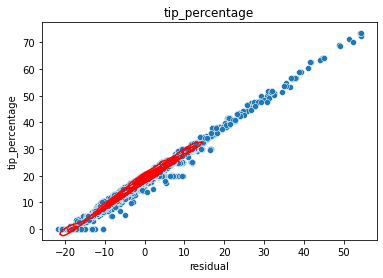

In [12]:
ax = sns.scatterplot(data=df_residual, x="residual", y=target_column)
ax = sns.kdeplot(data=df_residual, x="residual", y=target_column, color='red')
ax.set_title(target_column)
plt.show()

- As higher the percentage, higher the residual
- We have an error when the tip percentage is 0 and we predict wrongly around 20%.

For this reason 

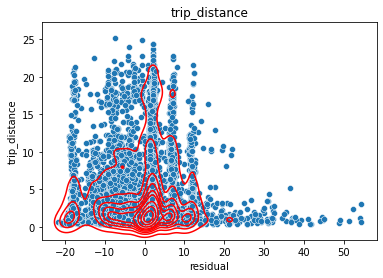

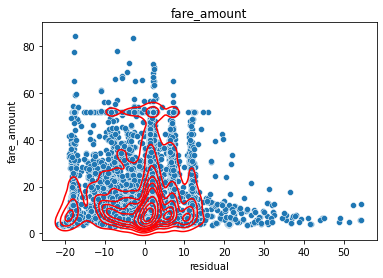

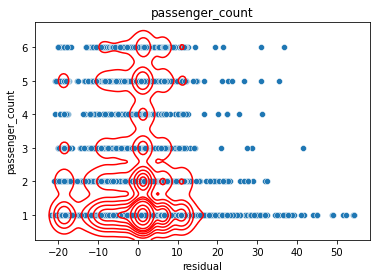

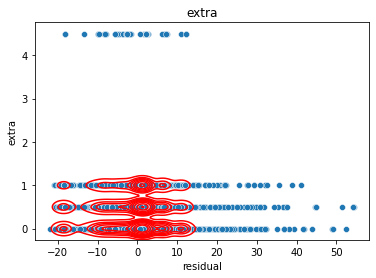

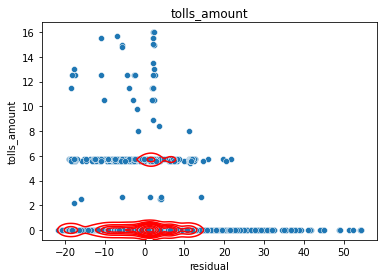

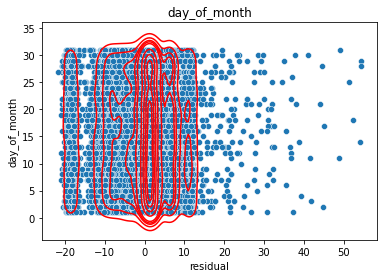

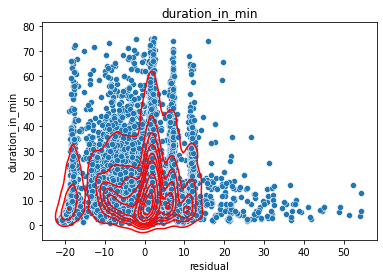

In [13]:
numeric_columns_to_review = ['trip_distance', 
    'fare_amount', 'passenger_count',
    'extra', 'tolls_amount',     
    'day_of_month',       
    'duration_in_min'
    ]

for column in numeric_columns_to_review:     
     ax = sns.scatterplot(data=df_residual, x="residual", y=column)
     ax = sns.kdeplot(data=df_residual, x="residual", y=column, color='red')          
     ax.set_title(column)
     plt.show()

- We have -20 residual when trip_distance and fare_amount are low

                                   residual
VendorID                                   
Creative Mobile Technologies, LLC  0.062293
VeriFone Inc                      -0.059695


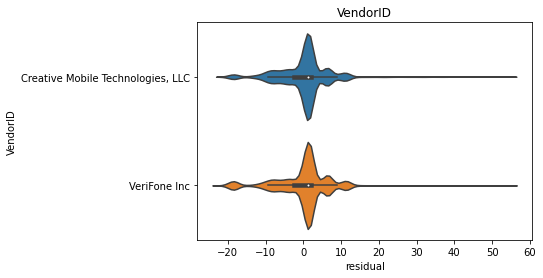

                       residual
RateCodeID                     
JFK                   -0.127178
Nassau or Westchester  1.840677
Negotiated fare        4.268230
Newark                -3.327645
Standard rate          0.000561


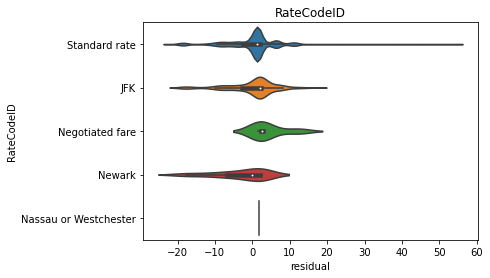

                    residual
store_and_fwd_flag          
N                  -0.008434
Y                   0.887896


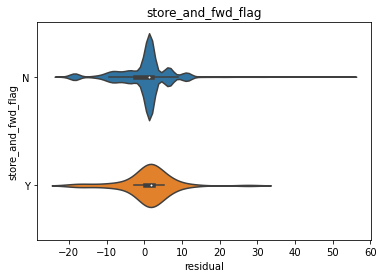

          residual
pu_month          
1         0.046176
3         0.212094
6        -0.143132
11       -0.011098
12       -0.155101


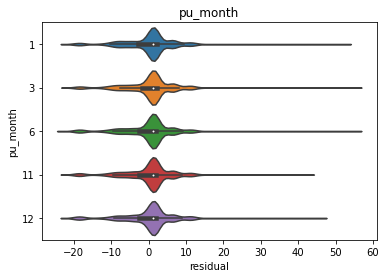

             residual
day_of_week          
1           -0.176975
2            0.089655
3            0.046229
4            0.199906
5            0.159768
6           -0.103933
7           -0.275426


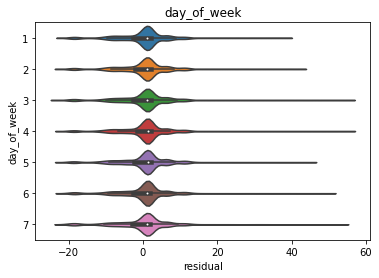

      residual
hour          
0    -0.079762
1    -0.370596
2    -0.600830
3    -0.294659
4    -0.633319
5    -0.525319
6    -0.872509
7    -0.409406
8    -0.597022
9    -0.437421
10   -0.135904
11   -0.427241
12   -0.042195
13    0.320569
14    0.264724
15    0.254549
16    0.092472
17    0.386229
18    0.315636
19    0.457664
20    0.088664
21   -0.165668
22    0.296954
23    0.228999


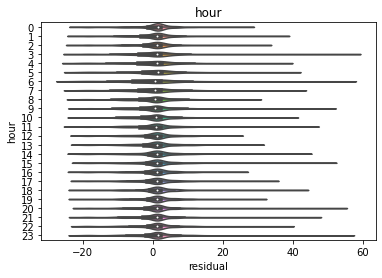

            residual
PU_Borough          
Bronx      -1.860414
Brooklyn    0.232969
Manhattan  -0.019958
Queens      0.192211


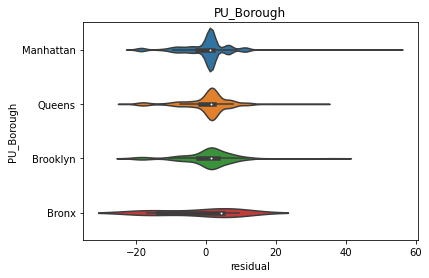

                 residual
PU_service_zone          
Airports         0.374066
Boro Zone       -0.631493
Yellow Zone      0.004392


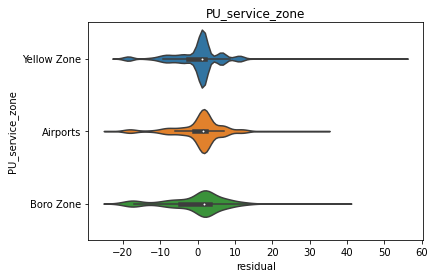

               residual
DO_Borough             
Bronx          2.161579
Brooklyn       0.478046
EWR           -3.327645
Manhattan     -0.044246
Queens         0.184779
Staten Island -0.865078


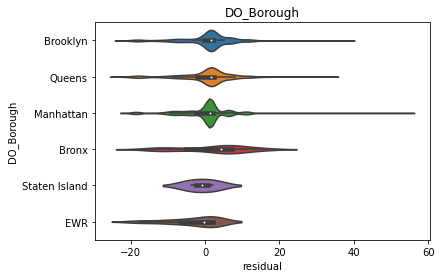

                 residual
DO_service_zone          
Airports         0.669166
Boro Zone        0.011562
EWR             -3.327645
Yellow Zone     -0.018850


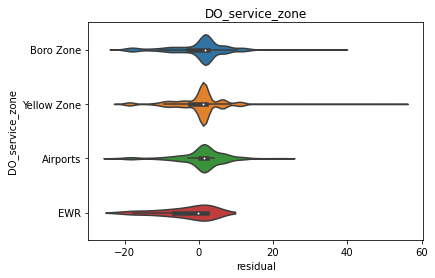

In [14]:
replace_map = {'VendorID': {
                   1: 'Creative Mobile Technologies, LLC',
                   2: 'VeriFone Inc'},
                'RateCodeID' : {
                    1: 'Standard rate', 2: 'JFK', 3: 'Newark', 
                    4: 'Nassau or Westchester', 5: 'Negotiated fare', 
                    6: 'Group ride'}
        }

df_residual_map = df_residual.replace(replace_map)
for column in category_columns:
     
     ax = sns.violinplot(data=df_residual_map, 
          x = "residual",
          y=column, orient='h')
     
     df_residual_avg = df_residual_map.groupby(column)\
        .agg({"residual":"mean"})#.orderBy(column)
     
     print(df_residual_avg)     
     
     ax.set_title(column)
     plt.show()

- Temporal features have similar residual patterns within the different values
- Rate codes have different patterns: negotiated fare has more residual dispersion
- Bronx borough has higher residual than other boroughs

For these reasons we could try to investigate with those specific cases. Even we could explore to create a model only for Bronx borough.

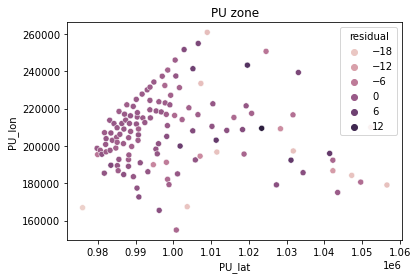

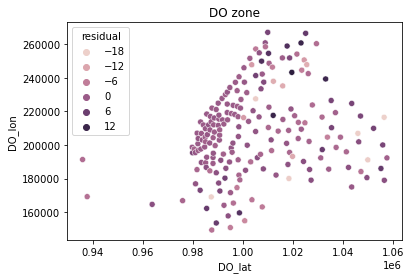

In [15]:
df_residual_agg = df_residual.groupby(['PU_lat', 'PU_lon']).agg({'residual':'mean'})
ax = sns.scatterplot(data=df_residual_agg, x='PU_lat', y='PU_lon', hue="residual")
ax.set_title(f"PU zone")
plt.show()

df_residual_agg = df_residual.groupby(["DO_lat", "DO_lon"]).agg({'residual':'mean'})
ax = sns.scatterplot(data=df_residual_agg, x="DO_lat", y=f"DO_lon", hue="residual")
ax.set_title(f"DO zone")
plt.show()

Some specific zones seem to have higher residuals. We could investigate further which are those zones, and probably we could create a new feature grouping zones that have similar behaviour.

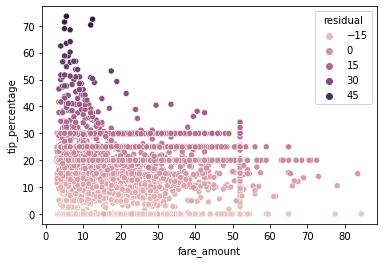

In [16]:
ax = sns.scatterplot(data=df_residual, x="fare_amount", y=target_column, hue="residual")
plt.show()

- We produce residuals (>30) when fare_amount is low and tip_percentage is high. We should investigat further the characteristics of those observations.
- We produce residuals of -15 when the tip_percentage is 0. We could investigate further these values. Even we could think about creating classification model that is able to predict if a trip will receive a tip or not. 